# IMPORT , CSV 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder

pd.set_option('display.max_rows', None)

train = pd.read_csv('./data/train_df.csv', encoding='cp949')
test  = pd.read_csv('./data/test_df.csv', encoding='cp949')
sub   = pd.read_csv('./data/sample_submission.csv', encoding='cp949')

In [2]:
train.shape, test.shape

((32000, 6), (4640, 5))

In [3]:
train.head()

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM,INVC_CONT
0,0,1129000014045300,5011000220046300,패션의류,상의,3
1,1,1135000009051200,5011000178037300,생활/건강,반려동물,3
2,2,1135000030093100,5011000265091400,패션의류,기타패션의류,9
3,3,1154500002014200,5011000315087400,식품,농산물,10
4,4,1165000021008300,5011000177051200,식품,가공식품,3


# TARGET 아웃라이어 제거

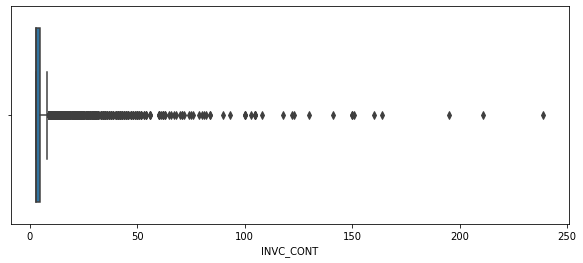

In [4]:
f,ax=plt.subplots(figsize=(10,4))
sns.boxplot(x=train['INVC_CONT'])
# sns.swarmplot(x=train['INVC_CONT'])
plt.show()

In [5]:
train_drop_index = train[train["INVC_CONT"] > 170].index

In [6]:
train.drop(index=train_drop_index, inplace=True)
train.reset_index(drop=True, inplace=True)

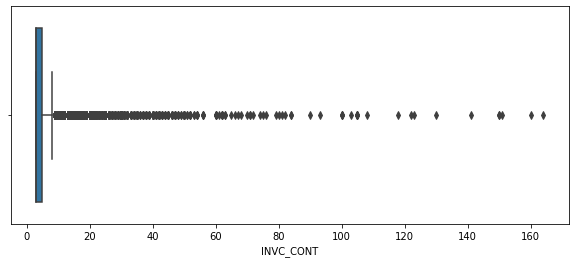

In [7]:
f,ax=plt.subplots(figsize=(10,4))
sns.boxplot(x=train['INVC_CONT'])
# sns.swarmplot(x=train['INVC_CONT'])
plt.show()

# EDA

In [8]:
df = pd.concat([train, test], axis=0)

In [9]:
df.shape

(36637, 6)

In [10]:
df.columns = ['index', 'send_num', 'receive_num', "cate_big", "cate_mid","target"]

In [11]:
df.head()

,index,send_num,receive_num,cate_big,cate_mid,target
0,0,1129000014045300,5011000220046300,패션의류,상의,3.0
1,1,1135000009051200,5011000178037300,생활/건강,반려동물,3.0
2,2,1135000030093100,5011000265091400,패션의류,기타패션의류,9.0
3,3,1154500002014200,5011000315087400,식품,농산물,10.0
4,4,1165000021008300,5011000177051200,식품,가공식품,3.0


In [12]:
df['send_num'].nunique(), df['receive_num'].nunique()

(3983, 31413)

In [13]:
df['send_num_3'] = df["send_num"].astype('str').str[:3].astype('int64')
df['send_num_4'] = df['send_num'].astype('str').str[:4].astype('int64')
df['send_num_7'] = df['send_num'].astype('str').str[:7].astype('int64')
df['send_num_8'] = df['send_num'].astype('str').str[:8].astype('int64')
df['send_num_9'] = df['send_num'].astype('str').str[:9].astype('int64')


In [14]:
df['rec_num_3'] = df["receive_num"].astype('str').str[:3].astype('int64')
df['rec_num_4'] = df['receive_num'].astype('str').str[:4].astype('int64')
df['rec_num_7'] = df['receive_num'].astype('str').str[:7].astype('int64')
df['rec_num_8'] = df['receive_num'].astype('str').str[:8].astype('int64')
df['rec_num_9'] = df['receive_num'].astype('str').str[:9].astype('int64')


In [15]:
df.head()

,index,send_num,receive_num,cate_big,cate_mid,target,send_num_3,send_num_4,send_num_7,send_num_8,send_num_9,rec_num_3,rec_num_4,rec_num_7,rec_num_8,rec_num_9
0,0,1129000014045300,5011000220046300,패션의류,상의,3.0,112,1129,1129000,11290000,112900001,501,5011,5011000,50110002,501100022
1,1,1135000009051200,5011000178037300,생활/건강,반려동물,3.0,113,1135,1135000,11350000,113500000,501,5011,5011000,50110001,501100017
2,2,1135000030093100,5011000265091400,패션의류,기타패션의류,9.0,113,1135,1135000,11350000,113500003,501,5011,5011000,50110002,501100026
3,3,1154500002014200,5011000315087400,식품,농산물,10.0,115,1154,1154500,11545000,115450000,501,5011,5011000,50110003,501100031
4,4,1165000021008300,5011000177051200,식품,가공식품,3.0,116,1165,1165000,11650000,116500002,501,5011,5011000,50110001,501100017


In [16]:
# 같은 곳에서 같은 곳으로 보내는

same_idx = df.loc[df['send_num'] == df['receive_num'], 'index'].index
df['same'] = 0

for idx in same_idx:
    df.loc[idx, 'same'] = 1

In [17]:
# 제주도 내의 물류

df.loc[(df['send_num_3'] == 501) | (df['rec_num_3'] == 501), '제주도' ] = 1

In [18]:
df['제주도'].fillna(0, inplace=True)

In [19]:
df[df['cate_big']== '식품']['cate_mid'].value_counts() #/ df['cate_mid'].count() #31785 = 식품

농산물          25401
음료            1293
수산            1075
가공식품          1057
기타식품           873
건강식품           739
축산             479
냉동/간편조리식품      468
과자             400
Name: cate_mid, dtype: int64

농산물 가중치

In [20]:
#  aa = (df[df['cate_mid']== '농산물']['cate_mid'].count() /  df[df['cate_big']== '식품']['cate_big'].count()) + 1
#  aa

In [21]:
df['gri'] = df['cate_mid'].apply(lambda x: 1 if x=='농산물' else 0)

In [22]:
df['cate_big'].unique()

array(['패션의류', '생활/건강', '식품', '화장품/미용', '여행/문화', '디지털/가전'], dtype=object)

In [23]:
df.drop(['index','send_num','receive_num'], axis=1, inplace=True)

In [24]:
df.head()

,cate_big,cate_mid,target,send_num_3,send_num_4,send_num_7,send_num_8,send_num_9,rec_num_3,rec_num_4,rec_num_7,rec_num_8,rec_num_9,same,제주도,gri
0,패션의류,상의,3.0,112,1129,1129000,11290000,112900001,501,5011,5011000,50110002,501100022,0,1.0,0
1,생활/건강,반려동물,3.0,113,1135,1135000,11350000,113500000,501,5011,5011000,50110001,501100017,0,1.0,0
2,패션의류,기타패션의류,9.0,113,1135,1135000,11350000,113500003,501,5011,5011000,50110002,501100026,0,1.0,0
3,식품,농산물,10.0,115,1154,1154500,11545000,115450000,501,5011,5011000,50110003,501100031,0,1.0,1
4,식품,가공식품,3.0,116,1165,1165000,11650000,116500002,501,5011,5011000,50110001,501100017,0,1.0,0


## 데이터 전처리

In [25]:
train = df[~df['target'].isna()]
test  = df[df['target'].isna()]

test.drop('target', axis=1, inplace=True)

print(df.shape, train.shape, test.shape)

(36637, 16) (31997, 16) (4640, 15)


g:\FINAL\venv\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [26]:
train['target'] = train['target'].astype('int64')

C:\Users\OST\AppData\Local\Temp/ipykernel_6212/1696841195.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['target'] = train['target'].astype('int64')


In [27]:
train.head()

,cate_big,cate_mid,target,send_num_3,send_num_4,send_num_7,send_num_8,send_num_9,rec_num_3,rec_num_4,rec_num_7,rec_num_8,rec_num_9,same,제주도,gri
0,패션의류,상의,3,112,1129,1129000,11290000,112900001,501,5011,5011000,50110002,501100022,0,1.0,0
1,생활/건강,반려동물,3,113,1135,1135000,11350000,113500000,501,5011,5011000,50110001,501100017,0,1.0,0
2,패션의류,기타패션의류,9,113,1135,1135000,11350000,113500003,501,5011,5011000,50110002,501100026,0,1.0,0
3,식품,농산물,10,115,1154,1154500,11545000,115450000,501,5011,5011000,50110003,501100031,0,1.0,1
4,식품,가공식품,3,116,1165,1165000,11650000,116500002,501,5011,5011000,50110001,501100017,0,1.0,0


In [28]:
# # scaling
# scaler = StandardScaler()

# scaler.fit(train)

In [29]:
# 원핫 인코딩
train_one = pd.get_dummies(train)
test_one = pd.get_dummies(test)

In [30]:
pd.set_option('display.max_rows', None)
train_one.head()

,target,send_num_3,send_num_4,send_num_7,send_num_8,send_num_9,rec_num_3,rec_num_4,rec_num_7,rec_num_8,...,cate_mid_문화컨텐츠,cate_mid_반려동물,cate_mid_상의,cate_mid_생활용품,cate_mid_수산,cate_mid_스킨케어,cate_mid_음료,cate_mid_음반,cate_mid_주방용품,cate_mid_축산
0,3,112,1129,1129000,11290000,112900001,501,5011,5011000,50110002,...,0,0,1,0,0,0,0,0,0,0
1,3,113,1135,1135000,11350000,113500000,501,5011,5011000,50110001,...,0,1,0,0,0,0,0,0,0,0
2,9,113,1135,1135000,11350000,113500003,501,5011,5011000,50110002,...,0,0,0,0,0,0,0,0,0,0
3,10,115,1154,1154500,11545000,115450000,501,5011,5011000,50110003,...,0,0,0,0,0,0,0,0,0,0
4,3,116,1165,1165000,11650000,116500002,501,5011,5011000,50110001,...,0,0,0,0,0,0,0,0,0,0


In [31]:
print(train_one.shape, test_one.shape)

(31997, 40) (4640, 39)


## 모델링

In [32]:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor 
train_Y = train_one['target']
train_X = train_one.drop('target',axis = 1)
test_X = test_one

#모델 정의
model = CatBoostRegressor(random_seed=27)

In [33]:
model.fit(train_X, train_Y)

Learning rate set to 0.072329
0:	learn: 5.3667261	total: 174ms	remaining: 2m 54s
1:	learn: 5.3565246	total: 179ms	remaining: 1m 29s
2:	learn: 5.3497786	total: 184ms	remaining: 1m 1s
3:	learn: 5.3428311	total: 189ms	remaining: 47.1s
4:	learn: 5.3352825	total: 194ms	remaining: 38.6s
5:	learn: 5.3306063	total: 199ms	remaining: 33s
6:	learn: 5.3245035	total: 204ms	remaining: 28.9s
7:	learn: 5.3124821	total: 208ms	remaining: 25.8s
8:	learn: 5.3066618	total: 212ms	remaining: 23.3s
9:	learn: 5.3023615	total: 216ms	remaining: 21.4s
10:	learn: 5.2988216	total: 220ms	remaining: 19.8s
11:	learn: 5.2950052	total: 224ms	remaining: 18.4s
12:	learn: 5.2911088	total: 227ms	remaining: 17.3s
13:	learn: 5.2791561	total: 231ms	remaining: 16.3s
14:	learn: 5.2757530	total: 235ms	remaining: 15.5s
15:	learn: 5.2732578	total: 239ms	remaining: 14.7s
16:	learn: 5.2701117	total: 243ms	remaining: 14.1s
17:	learn: 5.2681451	total: 247ms	remaining: 13.5s
18:	learn: 5.2652105	total: 251ms	remaining: 13s
19:	learn: 5.

In [34]:
# test 데이터 예측
pred = model.predict(test_X)

In [38]:
sum(pred <0 )

0

In [36]:
sub['INVC_CONT'] = pred

In [39]:
sub.to_csv("./sub/ost_06_outlier.csv", index=False)